In [1]:
!python -V

Python 3.10.12


In [2]:
!pip list

Package                  Version
------------------------ ---------
absl-py                  1.4.0
anyio                    3.6.2
appnope                  0.1.3
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
array-record             0.2.0
arrow                    1.2.3
asttokens                2.2.1
astunparse               1.6.3
attrs                    23.1.0
backcall                 0.2.0
beautifulsoup4           4.12.2
bleach                   6.0.0
cachetools               5.3.0
certifi                  2023.5.7
cffi                     1.15.1
charset-normalizer       3.1.0
click                    8.1.3
comm                     0.1.3
contourpy                1.0.7
cycler                   0.11.0
debugpy                  1.6.7
decorator                5.1.1
defusedxml               0.7.1
dm-tree                  0.1.8
etils                    1.3.0
exceptiongroup           1.1.1
executing                1.2.0
fastjsonschema           2.16.3
flatbuffers            

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 1. Load VGG16 Model

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [7]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False ## Not trainable weights
print("model summary 1")
base_model.summary()
print("Is layer Not trainable weights?")
for layer in base_model.layers:
    print(layer, layer.trainable)

model summary 1
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 1

# 2. Fine Chuning Model

In [8]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping

In [9]:
model = Sequential()

model.add(base_model)

model.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu")) 
model.add(Dense(64, activation="relu")) 
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [10]:
for layer in model.layers:
    print(layer, layer.trainable )

print(len(model.trainable_weights))

<keras.src.engine.functional.Functional object at 0x17b7ea6e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x17b6833d0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x17f926e90> True
<keras.src.layers.regularization.dropout.Dropout object at 0x17b7351e0> True
<keras.src.layers.reshaping.flatten.Flatten object at 0x17f926a70> True
<keras.src.layers.core.dense.Dense object at 0x17f927e50> True
<keras.src.layers.regularization.dropout.Dropout object at 0x17b66f850> True
<keras.src.layers.core.dense.Dense object at 0x17b66f6d0> True
<keras.src.layers.core.dense.Dense object at 0x148c3d9c0> True
<keras.src.layers.regularization.dropout.Dropout object at 0x148c3dc90> True
<keras.src.layers.core.dense.Dense object at 0x103796590> True
10


In [11]:
from keras.callbacks import EarlyStopping

In [12]:
model.compile(
    optimizer= 'adam', 
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 4, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                        

# 3. Remove dodgy images

In [14]:
import cv2
import imghdr

In [15]:
data_dir = 'data3' 

In [16]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [18]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data3/0_non-poison/IX3eN0R.jpeg
Image not in ext list data3/0_non-poison/.DS_Store
Image not in ext list data3/0_non-poison/original.jpeg
Image not in ext list data3/0_non-poison/03997386.jpg
Image not in ext list data3/0_non-poison/red_sand_boa_eryx_johnii_by_ashahar_alias_krishna_khan.jpg
Image not in ext list data3/0_non-poison/efe0d8908707940f.jpg


# 4. Load Data

In [19]:
import numpy as np
from matplotlib import pyplot as plt

In [20]:
data= tf.keras.utils.image_dataset_from_directory('data3')

Found 735 files belonging to 2 classes.


In [21]:
data_iterator = data.as_numpy_iterator()

2023-07-13 16:10:20.566541: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [735]
	 [[{{node Placeholder/_4}}]]
2023-07-13 16:10:20.567088: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [735]
	 [[{{node Placeholder/_0}}]]


In [22]:
batch = data_iterator.next()

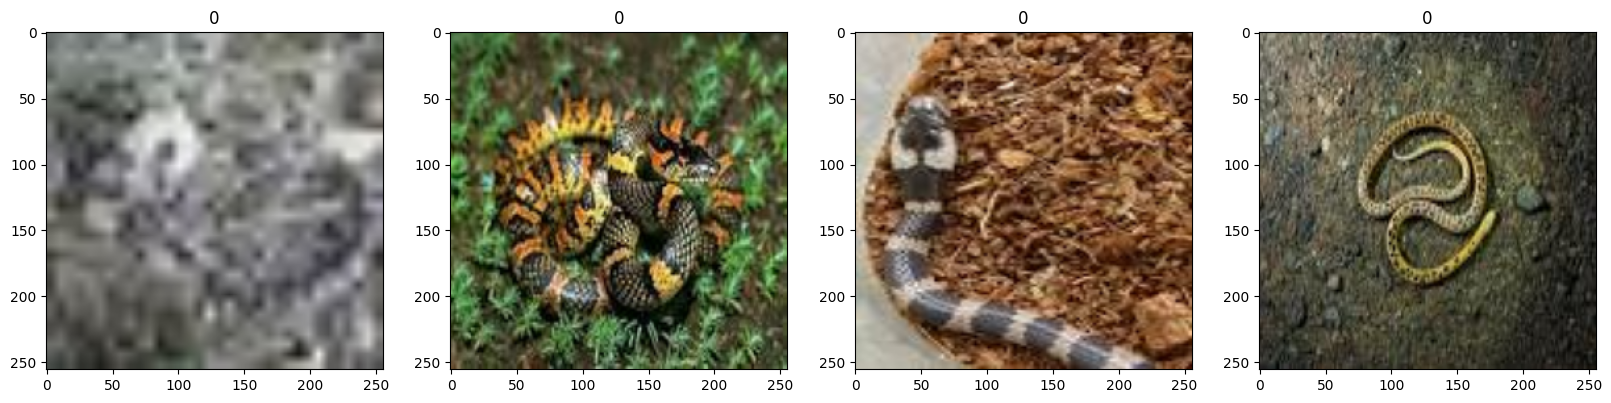

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 5. Scale Data

In [25]:
data = data.map(lambda x,y: (x/255, y))

In [26]:
data.as_numpy_iterator().next()

2023-07-13 16:11:38.988497: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [735]
	 [[{{node Placeholder/_4}}]]
2023-07-13 16:11:38.988864: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [735]
	 [[{{node Placeholder/_4}}]]


(array([[[[0.46666667, 0.41568628, 0.39215687],
          [0.470144  , 0.4191636 , 0.3956342 ],
          [0.47422642, 0.4238128 , 0.4002834 ],
          ...,
          [0.2856158 , 0.22735907, 0.20746782],
          [0.3290441 , 0.25712317, 0.23751532],
          [0.35686275, 0.27450982, 0.25490198]],
 
         [[0.45876226, 0.40778187, 0.38425246],
          [0.4636998 , 0.4127194 , 0.3886059 ],
          [0.46985352, 0.4194399 , 0.3946883 ],
          ...,
          [0.283219  , 0.22496228, 0.20507103],
          [0.33007592, 0.25815496, 0.23854712],
          [0.36081496, 0.27846202, 0.25885418]],
 
         [[0.43780637, 0.38682598, 0.36329657],
          [0.44661516, 0.39563477, 0.36997277],
          [0.45826024, 0.40784663, 0.37985477],
          ...,
          [0.2768647 , 0.21860798, 0.19871673],
          [0.33281136, 0.2608904 , 0.24128257],
          [0.3712929 , 0.28893995, 0.2693321 ]],
 
         ...,
 
         [[0.04276961, 0.04276961, 0.03795956],
          [0.04956

# 6. Split Data

In [27]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

In [28]:
len(data)

23

In [29]:
train_size

16

In [30]:
val_size

4

In [31]:
test_size

3

In [32]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 7. Train

In [33]:
logdir='logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-07-13 16:11:52.370975: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [735]
	 [[{{node Placeholder/_4}}]]
2023-07-13 16:11:52.371385: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [735]
	 [[{{node Placeholder/_4}}]]


16/16 [==============================] - ETA: 0s - loss: 0.7853 - accuracy: 0.4941  

2023-07-13 17:00:53.019049: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [735]
	 [[{{node Placeholder/_4}}]]
2023-07-13 17:00:53.019207: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [735]
	 [[{{node Placeholder/_4}}]]


16/16 [==============================] - 2957s 197s/step - loss: 0.7853 - accuracy: 0.4941 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/20


2023-07-13 17:03:36.749818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 185 of 256
2023-07-13 17:03:36.797659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 186 of 256
2023-07-13 17:03:36.797666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 187 of 256
2023-07-13 17:03:36.797669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 188 of 256
2023-07-13 17:03:36.798358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 189 of 256
2023-07-13 17:03:36.798364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 190 of 256
2023-07-13 17:03:36.798651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer 

16/16 [==============================] - 237s 6s/step - loss: 0.7093 - accuracy: 0.4805 - val_loss: 0.6889 - val_accuracy: 0.5234
Epoch 3/20
16/16 [==============================] - 100s 6s/step - loss: 0.6983 - accuracy: 0.5352 - val_loss: 0.6822 - val_accuracy: 0.6250
Epoch 4/20
16/16 [==============================] - 100s 6s/step - loss: 0.6891 - accuracy: 0.5508 - val_loss: 0.6736 - val_accuracy: 0.6250
Epoch 5/20
16/16 [==============================] - 101s 6s/step - loss: 0.6737 - accuracy: 0.5801 - val_loss: 0.6332 - val_accuracy: 0.6562
Epoch 6/20
16/16 [==============================] - 102s 6s/step - loss: 0.6698 - accuracy: 0.5703 - val_loss: 0.6080 - val_accuracy: 0.6641
Epoch 7/20
16/16 [==============================] - 103s 6s/step - loss: 0.6425 - accuracy: 0.6328 - val_loss: 0.6440 - val_accuracy: 0.6250
Epoch 8/20
16/16 [==============================] - 103s 7s/step - loss: 0.5972 - accuracy: 0.6582 - val_loss: 0.5852 - val_accuracy: 0.6641
Epoch 9/20
16/16 [======

# 8. Plot Performance

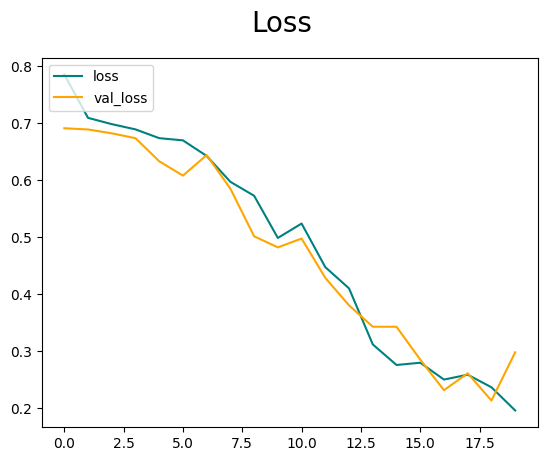

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

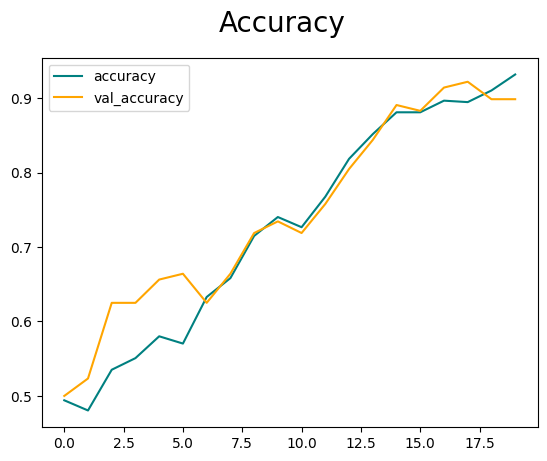

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate by test

In [38]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-07-13 18:15:24.658626: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [735]
	 [[{{node Placeholder/_4}}]]
2023-07-13 18:15:24.659010: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [735]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 4s 4s/step


In [41]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.972973, shape=(), dtype=float32) tf.Tensor(0.8181818, shape=(), dtype=float32) tf.Tensor(0.9052632, shape=(), dtype=float32)


# 10. Save the Model

In [42]:
from keras.models import load_model

In [43]:
model.save(os.path.join('models','imageclassifier.h5'))

/Users/sakuhongenki/.venv/pre/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
new_model = load_model('models/imageclassifier.h5')

In [45]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 4s 4s/step


In [46]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.97727275, shape=(), dtype=float32) tf.Tensor(0.84313726, shape=(), dtype=float32) tf.Tensor(0.9052632, shape=(), dtype=float32)
